In [131]:

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

torch.cuda.empty_cache()


True
NVIDIA GeForce RTX 2060


In [132]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

# ---------------------------
# Datasets and Generator
# ---------------------------


SPECTROGRAM_DIR = r"D:\Music-Classification\dataset\Data\images_original"
CSV_DIR = r"D:\Music-Classification\resnet\data"
TRAIN_CSV = os.path.join(CSV_DIR, "train.csv")
VAL_CSV = os.path.join(CSV_DIR, "valid.csv")
TEST_CSV = os.path.join(CSV_DIR, "test.csv")

train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Label map
def build_label_map(df):
    labels = sorted(df['genre'].unique())
    return {label: idx for idx, label in enumerate(labels)}

label_map = build_label_map(train_df)
inv_label_map = {v: k for k, v in label_map.items()}
num_classes = len(label_map)


class SpectrogramDataset(Dataset):
    def __init__(self, df, label_map, img_root, transform=None):
        self.df = df
        self.label_map = label_map
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_name = row['file_name'] 
        genre = row['genre']

  
        base, ext = os.path.splitext(file_name)  
        genre_name, number = base.split('.')     
        fname = f"{genre_name}{int(number):05d}.png"  
        img_path = os.path.join(self.img_root, genre_name, fname)

       
        image = Image.open(img_path).convert('RGB')
        label = self.label_map[genre]
        if self.transform:
            image = self.transform(image)
        return image, label

In [133]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 64

train_dataset = SpectrogramDataset(train_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)
val_dataset = SpectrogramDataset(val_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)
test_dataset = SpectrogramDataset(test_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [134]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim

base_name = "GPU_resnet50_Noneeweights_bath64_30_Adam1e-4_benchmark"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Premade PyTorch (Meta) ResNet50
# ---------------------------
model = models.resnet50(weights=None)
#model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
#model.fc = nn.Sequential(nn.Dropout(0.9),nn.Linear(model.fc.in_features, num_classes)) # Dropout 
#model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 512),nn.ReLU(),nn.Dropout(0.5),nn.Linear(512, num_classes)) # ReLU + Dropout
model.fc = nn.Linear(model.fc.in_features, num_classes) #basic
model = model.to(device)

# ---------------------------
# ResNet18
# ---------------------------

# model = models.resnet18(weights=None)  
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4) 
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)#  weight_decay=
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)

In [135]:
import torch
import numpy as np
import copy
from sklearn.metrics import precision_score
import pickle

def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    num_epochs=50, patience=10, base_name="model"
):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_prec': [], 'val_prec': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, running_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / running_total
        train_acc = running_corrects.double().item() / running_total
        train_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)

        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        val_preds, val_labels_list = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)
                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())

        val_loss = val_loss / val_total
        val_acc = val_corrects.double().item() / val_total
        val_prec = precision_score(val_labels_list, val_preds, average='macro', zero_division=0)

        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, prec: {train_prec:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, prec: {val_prec:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_prec'].append(train_prec)
        history['val_prec'].append(val_prec)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, f"{base_name}.pt")
            patience_counter = 0
            print(f"[ModelCheckpoint] Best model saved at epoch {epoch+1} with val_acc={val_acc:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("[EarlyStopping] Patience exceeded. Stopping training.")
            break

    model.load_state_dict(best_model_wts)
    return model, history


with open(f"{base_name}.pkl", 'wb') as f:
    pickle.dump(history, f)


In [136]:
# # ---------------------------
# # Compile and Train
# # ---------------------------

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=15)


Epoch 1/30 | Train loss: 2.2890, acc: 0.1531, prec: 0.1809 | Val loss: 2.5745, acc: 0.1000, prec: 0.0100
[ModelCheckpoint] Best model saved at epoch 1 with val_acc=0.1000
Epoch 2/30 | Train loss: 2.0625, acc: 0.2690, prec: 0.2831 | Val loss: 4.1078, acc: 0.1000, prec: 0.0100
Epoch 3/30 | Train loss: 1.7736, acc: 0.4020, prec: 0.3813 | Val loss: 5.1090, acc: 0.1000, prec: 0.0100
Epoch 4/30 | Train loss: 1.6208, acc: 0.4020, prec: 0.4003 | Val loss: 3.1786, acc: 0.1867, prec: 0.0839
[ModelCheckpoint] Best model saved at epoch 4 with val_acc=0.1867
Epoch 5/30 | Train loss: 1.4901, acc: 0.4764, prec: 0.4658 | Val loss: 2.3334, acc: 0.2333, prec: 0.1889
[ModelCheckpoint] Best model saved at epoch 5 with val_acc=0.2333
Epoch 6/30 | Train loss: 1.4633, acc: 0.4807, prec: 0.4706 | Val loss: 1.9489, acc: 0.2800, prec: 0.3767
[ModelCheckpoint] Best model saved at epoch 6 with val_acc=0.2800
Epoch 7/30 | Train loss: 1.3075, acc: 0.5322, prec: 0.5402 | Val loss: 1.5389, acc: 0.4333, prec: 0.4105
[

In [137]:
# # ---------------------------
# # Evaluate & Plot
# # ---------------------------

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_model(model, test_loader)

test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision:.4f}")
print(f"Test Recall (macro): {test_recall:.4f}")
print(f"Test F1 Score (macro): {test_f1:.4f}")



Test Accuracy: 0.6267
Test Precision (macro): 0.6358
Test Recall (macro): 0.6267
Test F1 Score (macro): 0.6193


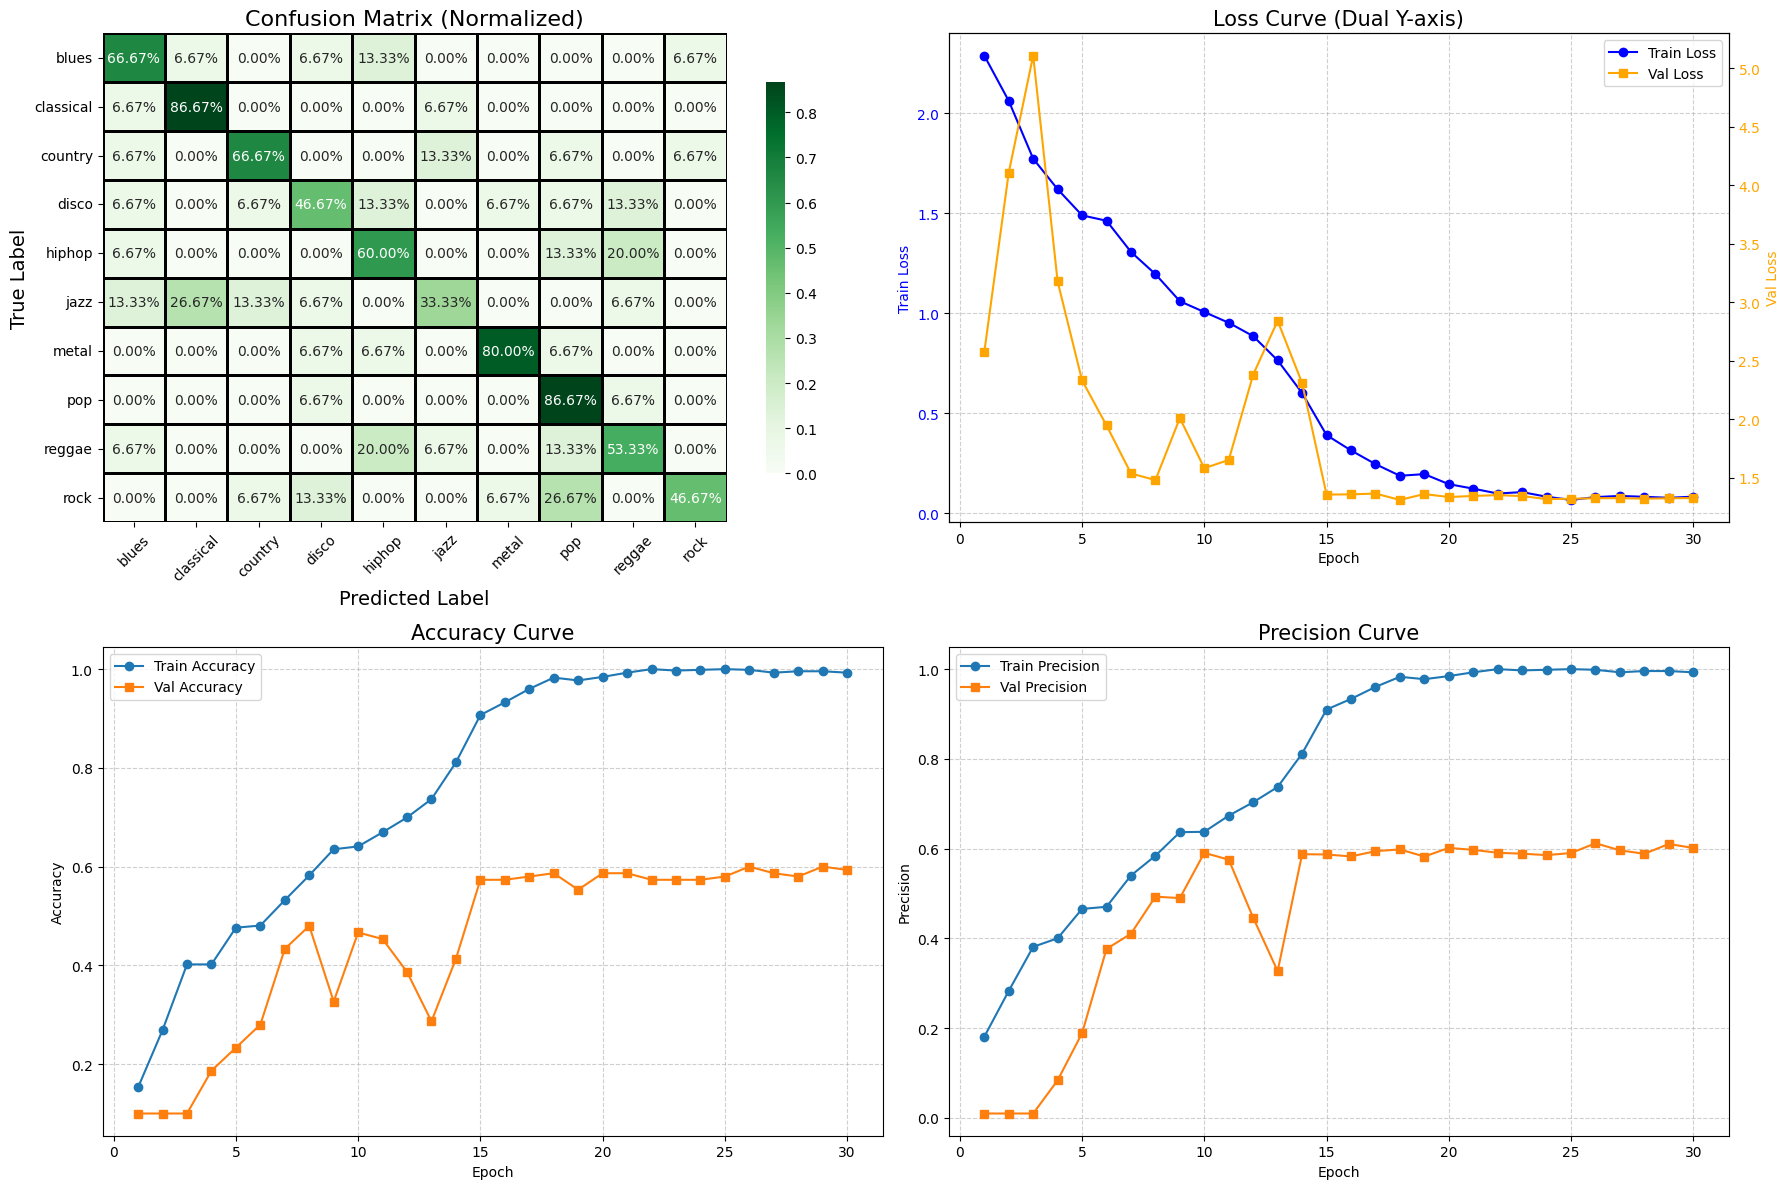

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns


epochs = range(1, len(history['train_loss']) + 1)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

cm_norm = conf_matrix.astype('float') / (conf_matrix.sum(axis=1, keepdims=True) + 1e-8)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap="Greens",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8},
            ax=axs[0, 0])
axs[0, 0].set_xlabel('Predicted Label', fontsize=14)
axs[0, 0].set_ylabel('True Label', fontsize=14)
axs[0, 0].set_title('Confusion Matrix (Normalized)', fontsize=16)
axs[0, 0].tick_params(axis='x', rotation=45)

ax1 = axs[0, 1]
line1, = ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Loss Curve (Dual Y-axis)', fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.6)
ax2 = ax1.twinx()
line2, = ax2.plot(epochs, history['val_loss'], 'orange', marker='s', label='Val Loss')
ax2.set_ylabel('Val Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

axs[1, 0].plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
axs[1, 0].plot(epochs, history['val_acc'], label='Val Accuracy', marker='s')
axs[1, 0].set_title('Accuracy Curve', fontsize=15)
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)
axs[1, 0].legend()

axs[1, 1].plot(epochs, history['train_prec'], label='Train Precision', marker='o')
axs[1, 1].plot(epochs, history['val_prec'], label='Val Precision', marker='s')
axs[1, 1].set_title('Precision Curve', fontsize=15)
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)
axs[1, 1].legend()

plt.tight_layout()
plt.show()
